In [15]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [16]:
!python -m pip install git+https://github.com/Alec-Schneider/imbalanced-dataset-sampler

  Cloning https://github.com/Alec-Schneider/imbalanced-dataset-sampler to /tmp/pip-req-build-s28t_nj9
  Running command git clone -q https://github.com/Alec-Schneider/imbalanced-dataset-sampler /tmp/pip-req-build-s28t_nj9
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3866 sha256=0209864a04d9b78bad031ab30ddfe8a00462e76c8fd60a623bae661fb6214840
  Stored in directory: /tmp/pip-ephem-wheel-cache-4d263w2x/wheels/ab/ad/ad/f195db826b91b699a5acd8ac61aff84148073e3fe1ad03706e
Successfully built torchsampler


In [17]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [18]:
!pip install plotly

  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [19]:
import logging 
import os 
import sys 
import numpy as np 
import pandas as pd 
import pickle
from typing import Callable
from types import SimpleNamespace

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.utils.data
import torchvision
from torchsummary import summary

from torchsampler import ImbalancedDatasetSampler


logger = logging.getLogger(__name__) 
logger.setLevel(logging.DEBUG) 
logger.addHandler(logging.StreamHandler(sys.stdout)) 

In [7]:
orig_train = pd.read_csv("data/exoTrain.csv")
orig_train['LABEL'] = orig_train['LABEL'] - 1

orig_train.sample(frac=1).to_csv("data/Train.csv", index=False)

In [8]:
orig_test = pd.read_csv("data/exoTest.csv")
orig_test['LABEL'] = orig_test['LABEL'] - 1
orig_test.sample(frac=1).to_csv("data/Test.csv", index=False)

In [9]:
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")
train.dtypes

LABEL          int64
FLUX.1       float64
FLUX.2       float64
FLUX.3       float64
FLUX.4       float64
              ...   
FLUX.3193    float64
FLUX.3194    float64
FLUX.3195    float64
FLUX.3196    float64
FLUX.3197    float64
Length: 3198, dtype: object

In [10]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,0,1.13,0.32,3.64,-2.55,-7.26,-3.95,-1.56,-0.46,0.04,...,2.75,2.53,-0.45,-7.41,-2.40,-5.30,-4.25,-0.02,-2.22,-0.60
1,0,-24.34,-19.58,-12.05,-14.69,-10.31,-7.60,-8.63,-11.85,11.78,...,5.01,-6.73,4.52,1.03,-1.72,-1.32,-4.23,880.28,0.25,-8.84
2,0,6.00,7.70,2.87,4.32,5.63,4.79,0.10,-4.40,-1.04,...,-5.91,-0.97,-0.62,-2.48,0.50,4.48,-1.00,-5.57,-3.41,14.00
3,0,-47.72,-54.29,-53.11,-53.47,-55.80,-55.01,-53.97,-53.72,-40.51,...,40.19,38.52,23.02,26.29,29.07,35.92,-70.71,-19.82,-5.67,4.48
4,0,9.01,-4.29,4.34,-1.24,0.36,2.25,0.20,6.75,-6.04,...,0.34,-0.37,-0.92,12.53,4.18,5.10,-2.42,-0.30,-1.94,-0.47


In [11]:
train.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,0.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,0.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,0.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,0.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,0.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [12]:
trainT = train.T
trainT.head()

,0,1,2,3,4,5,6,7,8,9,...,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086
LABEL,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FLUX.1,1.13,-24.34,6.00,-47.72,9.01,5.75,-413.82,-2.85,-624.43,35.86,...,39.84,375.08,-738.50,-259.91,-5.19,281.92,265.28,-155.50,3.86,-27.00
FLUX.2,0.32,-19.58,7.70,-54.29,-4.29,12.48,-415.88,2.66,-515.56,12.77,...,40.44,378.72,-955.13,-264.97,10.68,237.16,244.11,-42.25,-1.44,-38.31
FLUX.3,3.64,-12.05,2.87,-53.11,4.34,-27.54,-411.29,-3.45,-497.81,12.39,...,53.52,251.97,-916.94,-247.56,11.44,215.55,236.61,-27.25,-6.63,-43.80
FLUX.4,-2.55,-14.69,4.32,-53.47,-1.24,-2.04,-388.54,-2.60,-472.00,14.67,...,40.47,394.27,-902.76,-234.96,41.75,234.83,190.09,-150.75,0.36,-74.36


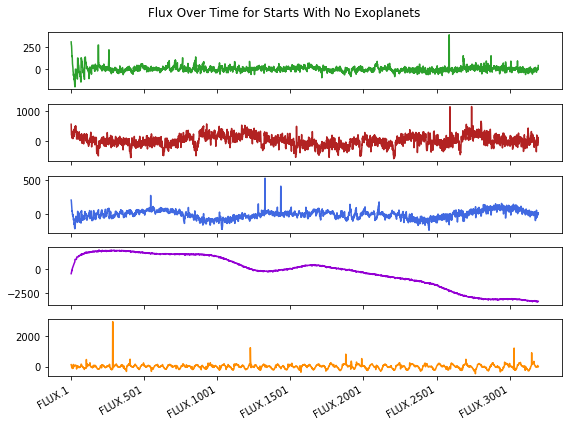

In [13]:
fig, ax = plt.subplots(5,1, figsize=(8,6))

colors = ('tab:green', 'firebrick', 'royalblue', 'darkviolet', 'darkorange')
for i, color in enumerate(colors):
    trainT.iloc[:, train[train['LABEL'] == 1].index.values].iloc[1:,i].plot(subplots=True,
                             title="Flux Over Time for Starts With No Exoplanets",
                            sharex=True, ax=ax.flat[i], color=color)
fig.tight_layout()
fig.savefig("data/exoplanets_wavelengths.png")

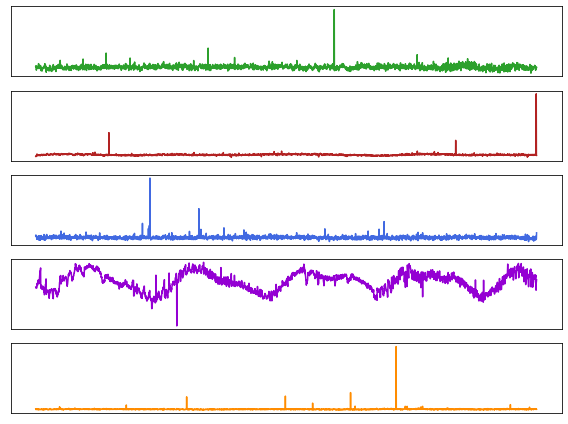

In [14]:
fig, axes = plt.subplots(5,1, figsize=(8,6))

colors = ('tab:green', 'firebrick', 'royalblue', 'darkviolet', 'darkorange')
for i, color in enumerate(colors):
    ax = axes.flat[i]
    trainT.iloc[:, train[train['LABEL'] == 0].index.values].iloc[1:,i].plot(subplots=True,
                            sharex=True, ax=ax, color=color)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
fig.savefig("data/no_exoplanets_wavelengths.png")

### SCale the training data and add 1d uniform filter as a second channel to the data

In [26]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train.iloc[:, 1:])
y_train = train['LABEL']

x_test_scaled = scaler.transform(test.iloc[:, 1:])
y_test = test['LABEL']

In [82]:
pickle.dump(scaler, open('./data/scaler.pkl', 'wb'))

In [27]:
x_train_scaled_filt = np.stack([x_train_scaled, uniform_filter1d(x_train_scaled, axis=1, size=200)], axis=2)
x_test_scaled_filt = np.stack([x_test_scaled, uniform_filter1d(x_test_scaled, axis=1, size=200)], axis=2)

In [31]:
arr_reshaped = x_train_scaled_filt.reshape(x_train_scaled_filt.shape[0], -1)
np.savetxt('data/x_train_scaled__filt.txt', arr_reshaped)

# retrieving data from file.
loaded_arr = np.loadtxt("data/x_train_scaled__filt.txt")
  
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // x_train_scaled_filt.shape[2], x_train_scaled_filt.shape[2])
  
# check the shapes:
print("shape of arr: ", x_train_scaled_filt.shape)
print("shape of load_original_arr: ", load_original_arr.shape)
  
# check if both arrays are same or not:
if (load_original_arr == x_train_scaled_filt).all():
    print("Yes, both the arrays are same")
else:
    print("No, both the arrays are not same")


shape of arr:  (5087, 3197, 2)
shape of load_original_arr:  (5087, 3197, 2)
Yes, both the arrays are same


In [84]:
arr_reshaped = x_test_scaled_filt.reshape(x_test_scaled_filt.shape[0], -1)
np.savetxt('data/x_test_scaled_filt.txt', arr_reshaped)

# retrieving data from file.
loaded_arr = np.loadtxt("data/x_test_scaled_filt.txt")
  
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)
  
# check the shapes:
print("shape of arr: ", x_test_scaled_filt.shape)
print("shape of load_original_arr: ", load_original_arr.shape)
  
# check if both arrays are same or not:
if (load_original_arr == x_test_scaled_filt).all():
    print("Yes, both the arrays are same")
else:
    print("No, both the arrays are not same")

shape of arr:  (570, 3197, 2)
shape of load_original_arr:  (570, 3197, 2)
Yes, both the arrays are same


In [ ]:
loaded_arr = np.loadtxt(os.path.join("training_dir", x_file))
features = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)



labels = pd.read_csv(os.path.join("./data", 'y_train.csv'))['LABEL'].values

tensor_labels = torch.tensor(labels)
tensor_features = torch.tensor(features)

dataset = TensorDataset(tensor_features, tensor_labels)

tensor_dataloader = DataLoader(dataset, batch_size=batch_size, 
                               sampler=ImbalancedDatasetSampler(dataset, labels))


In [83]:
y_train.to_csv("data/y_train.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

### Label Distribution

In [32]:
train_dist = pd.DataFrame(train.groupby(['LABEL']).size()).reset_index().rename({0: "count"}, axis=1)
train_dist['%'] = train_dist["count"] / len(train)
train_dist

,LABEL,count,%
0,0,5050,0.992727
1,1,37,0.007273


In [48]:
test_dist = pd.DataFrame(test.groupby(['LABEL']).size()).reset_index().rename({0: "count"}, axis=1)
test_dist['%'] = test_dist["count"] / len(test)
test_dist

,LABEL,count,%
0,0,565,0.991228
1,1,5,0.008772


### PCA with 2 Components

In [17]:
pca = PCA(2)
pca_train = pd.DataFrame(pca.fit_transform(train.iloc[:, 1:]))
pca_train['label'] = train['LABEL']
print(f"Explained variance {pca.explained_variance_ratio_}")
pca_train.shape

Explained variance [0.54352887 0.15767919]


(5087, 3)

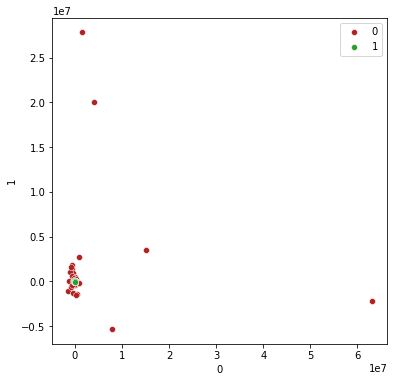

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6),)
for i, (color, marker) in enumerate(zip(('firebrick', 'tab:green'), ('o', 'o'))):
    sns.scatterplot(x=0, y=1, data=pca_train[pca_train['label'] == i], 
                    color=color, marker=marker, ax=ax, label=i)
fig.savefig("data/pca2_scatter.png")

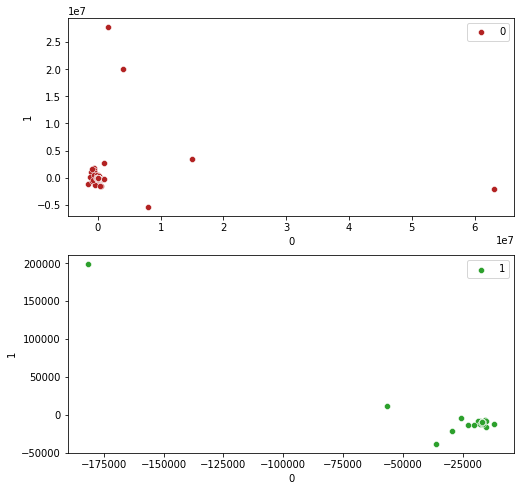

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8),)
for i, (color, marker) in enumerate(zip(('firebrick', 'tab:green'), ('o', 'o'))):
    sns.scatterplot(x=0, y=1, data=pca_train[pca_train['label'] == i], 
                    color=color, marker=marker, ax=axes.flat[i], label=i)
fig.savefig("data/pca2_scatter_subplots_nosharex.png")

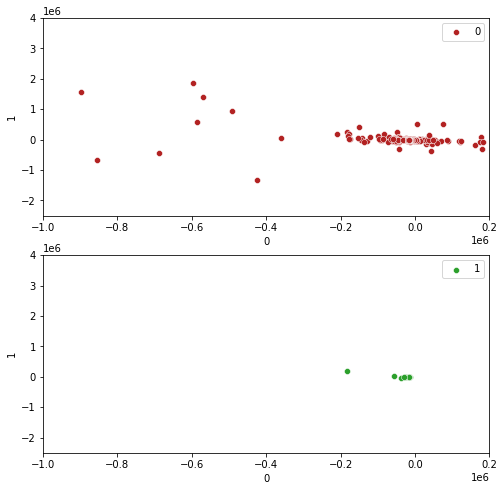

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8),)
for i, (color, marker) in enumerate(zip(('firebrick', 'tab:green'), ('o', 'o'))):
    sns.scatterplot(x=0, y=1, data=pca_train[pca_train['label'] == i], 
                    color=color, marker=marker, ax=axes.flat[i], label=i)
    axes.flat[i].set_ylim([-2.5e6, 4e6])
    axes.flat[i].set_xlim([-1.0e6, 0.2e6])

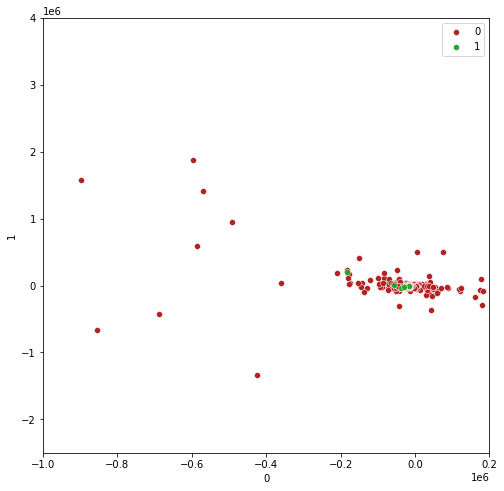

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),)
for i, (color, marker) in enumerate(zip(('firebrick', 'tab:green'), ('o', 'o'))):
    sns.scatterplot(x=0, y=1, data=pca_train[pca_train['label'] == i], 
                    color=color, marker=marker, ax=ax, label=i)
    ax.set_ylim([-2.5e6, 4e6])
    ax.set_xlim([-1.0e6, 0.2e6])
fig.savefig("data/pca2_zoomed.png")

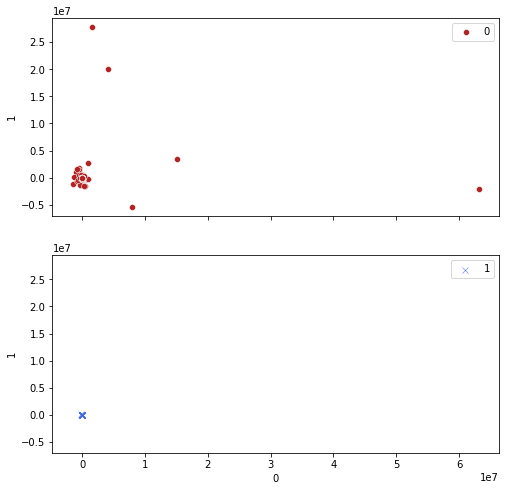

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
for i, (color, marker) in enumerate(zip(('firebrick', 'royalblue'), ('o', 'x'))):
    sns.scatterplot(x=0, y=1, data=pca_train[pca_train['label'] == i], 
                    color=color, marker=marker, ax=axes.flat[i], label=i)
fig.savefig("data/pca2_scatter_subplots_sharex.png")

### PCA With 3 Components

In [53]:
pca3 = PCA(3)
pca3_train = pd.DataFrame(pca3.fit_transform(train.iloc[:, 1:]))
pca3_train['label'] = train['LABEL'].astype('str')
print(f"Explained variance {pca3.explained_variance_ratio_}")
pca3_train.shape

Explained variance [0.54352887 0.15767919 0.10896863]


(5087, 4)

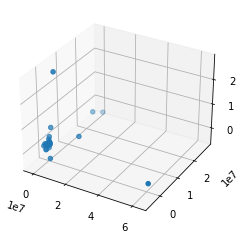

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca3_train[0], pca3_train[1], pca3_train[2])

(-1000000.0, 200000.0)

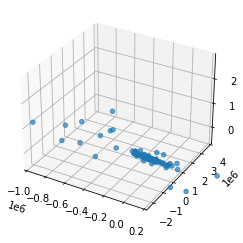

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca3_train[0], pca3_train[1], pca3_train[2])
ax.set_ylim([-2.5e6, 4e6])
ax.set_xlim([-1.0e6, 0.2e6])

In [59]:
fig = px.scatter_3d(pca3_train, x=0, y=1, z=2, color='label', title="3 Component PCA Visualization")
fig.write_html("data/pca3_plot.html")

In [210]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """
    class built by https://github.com/ufoym/imbalanced-dataset-sampler and needed to be modified for this code's TensorDataset,
    with no get_labels method
    
    Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, labels: list=None, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] =  self._get_labels(dataset) if labels is None else labels 
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [29]:
def get_data_loader(batch_size, training_dir, filename):
    logger.info("Get data loader")
    
    data = pd.read_csv(os.path.join(training_dir, filename))
    labels = data.LABEL.values
    features = data.loc[:, data.columns != "LABEL"].values
    
    tensor_labels = torch.tensor(labels)
    tensor_features = torch.tensor(features)
    
    dataset = TensorDataset(tensor_features, tensor_labels)
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return tensor_dataloader

In [55]:
def get_data_upsampled_loader(batch_size, training_dir, filename):
    logger.info("Get data loader")
    
    data = pd.read_csv(os.path.join(training_dir, filename))
    labels = data.LABEL.values
    features = data.loc[:, data.columns != "LABEL"].values
    
    tensor_labels = torch.tensor(labels)
    tensor_features = torch.tensor(features)
    
    dataset = TensorDataset(tensor_features, tensor_labels)
    
    class_weights = [1, 50] 
    sample_weights = [0] * len(dataset)
    
    for idx, (data, label) in enumerate(dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight
        
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights),
                                   replacement=True)
    
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    
    return tensor_dataloader

In [57]:
def get_data_imbalanced_loader(batch_size, training_dir, filename):
    logger.info("Get data loader")
    
    data = pd.read_csv(os.path.join(training_dir, filename))
    labels = data.LABEL.values
    features = data.loc[:, data.columns != "LABEL"].values
    
    tensor_labels = torch.tensor(labels)
    tensor_features = torch.tensor(features)
    
    dataset = TensorDataset(tensor_features, tensor_labels)
    
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, 
                                   sampler=ImbalancedDatasetSampler(dataset, labels))
    
    return tensor_dataloader

### View some batches of data

In [7]:
def get_data_imbalanced_loader(batch_size, training_dir, x_file, y_file):
    logger.info("Get data loader")
    
    loaded_arr = np.loadtxt(os.path.join(training_dir, x_file))
    features = loaded_arr.reshape(
        loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)
    
    labels = pd.read_csv(os.path.join("./data", 'y_train.csv'))['LABEL'].values
    
    tensor_labels = torch.tensor(labels)
    tensor_features = torch.tensor(features)
    
    dataset = TensorDataset(tensor_features, tensor_labels)
    
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, 
                                   sampler=ImbalancedDatasetSampler(dataset, labels))
    
    return tensor_dataloader

In [8]:
data_dir = "./data/"
# train_loader = get_data_loader(24, data_dir, "Train.csv")
# train_loader2 = get_data_imbalanced_loader(24, data_dir, "Train.csv")


In [10]:
train_data_loader = get_data_imbalanced_loader(24, "./data", 'x_train_scaled_filt.txt', 'y_train.csv')

Get data loader


In [11]:
batch = next(iter(train_data_loader))
print(batch[0].shape)
print(batch[1].shape)

[2022-03-06 14:19:21.997 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:1007 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-06 14:19:22.082 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:1007 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
torch.Size([24, 3197, 2])
torch.Size([24])


In [12]:
### With 1D data and no channel, we will need to add a channel on a new axis
batch_1 = batch[0]
print(batch_1.size())
input = torch.randn(32, 3197,2)
#### Rearrange the data as batch_size x channels x features
print(input.view(input.shape[0], input.shape[2], input.shape[1]).size())

torch.Size([24, 3197, 2])
torch.Size([32, 2, 3197])


In [15]:
### Test the CNN, MaxPooling, and BatchNorm Layers on a batch of data
m = nn.Conv1d(2,6, 3)
input_view = batch_1.view(batch_1.shape[0], batch_1.shape[2], batch_1.shape[1])
output = F.max_pool1d(F.relu(m(input_view.float())), 3)
# print(output.size())
print(output.size())
# print(20*16*48)
norm = nn.BatchNorm1d(6)
output = norm(output)
m2 = nn.Conv1d(6, 16, 3)
output =F.max_pool1d(F.relu(m2(output.float())), 3)
norm = nn.BatchNorm1d(16)
output = norm(output)
print(output.size())
m3 = nn.Conv1d(16, 32, 3)
output =F.max_pool1d(F.relu(m3(output.float())), 3)
norm = nn.BatchNorm1d(32)
output = norm(output)
print(output.size())
m4 = nn.Conv1d(32, 64, 3)
output =F.max_pool1d(F.relu(m4(output.float())), 3)
norm = nn.BatchNorm1d(64)
output = norm(output)
print(output.size())
# output.view(-1).size()
print(64 * 38)

torch.Size([24, 6, 1065])
torch.Size([24, 16, 354])
torch.Size([24, 32, 117])
torch.Size([24, 64, 38])
2432


In [ ]:
### Test the CNN, MaxPooling, and BatchNorm Layers on a batch of data
m = nn.Conv1d(2,6, 3)
input_view = batch_1.view(batch_1.shape[0], batch_1.shape[2], batch_1.shape[1])
output = F.max_pool1d(F.relu(m(input_view.float())), 3)
# print(output.size())
print(output.size())
print(20*16*48)
norm = nn.BatchNorm1d(6)
output = norm(output)
m2 = nn.Conv1d(6, 16, 3)
output =F.max_pool1d(F.relu(m2(output.float())), 3)
norm = nn.BatchNorm1d(16)
output = norm(output)
print(output.size())
# output.view(-1).size()
print(16 * 354)

In [78]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 6, 3)
        self.b_norm1 = nn.BatchNorm1d(6)
        self.conv2 = nn.Conv1d(6, 16, 3)
        self.b_norm2 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16 * 354, 500)
        self.fc2 = nn.Linear(500, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Transform the input shape of the batch 
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = self.b_norm1(x) 
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = self.b_norm2(x)
        x = x.view(-1, 16 * 354)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [79]:
cnn = CNN()
print(batch[0].size())
out = cnn(batch[0].float())
out.size()

torch.Size([24, 3197, 2])


torch.Size([24, 1])

In [124]:
out

tensor([[0.4995],
        [0.4865],
        [0.4841],
        [0.4910],
        [0.4861],
        [0.4916],
        [0.5011],
        [0.4865],
        [0.4835],
        [0.5023],
        [0.4832],
        [0.5041],
        [0.4940],
        [0.4831],
        [0.4810],
        [0.4656],
        [0.5133],
        [0.4834],
        [0.4973],
        [0.4832],
        [0.4832],
        [0.4861],
        [0.5124],
        [0.5927]], grad_fn=<SigmoidBackward>)

In [168]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.l_1 = nn.Linear(3197, 5000)
        self.l_2 = nn.Linear(5000, 10000)
        self.l_3 = nn.Linear(10000, 5000)
        self.l_4 = nn.Linear(5000, 2500)
        self.l_5 = nn.Linear(2500, 250)
        self.l_6 = nn.Linear(250, 1)

        
    def forward(self, x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.l_2(x))
        x = F.relu(self.l_3(x))
        x = F.relu(self.l_4(x))
        x = F.relu(self.l_5(x))
        x = torch.sigmoid(self.l_6(x))
        return  x

In [169]:
class ShallowBinaryClassifier(nn.Module):
    def __init__(self):
        super(ShallowBinaryClassifier, self).__init__()
        self.l_1 = nn.Linear(3197, 5000)
        self.b_norm1 = nn.BatchNorm1d(5000)
        self.l_2 = nn.Linear(5000, 1)

        
    def forward(self, x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.b_norm1(x))
        x = torch.sigmoid(self.l_2(x))
        return  x

In [34]:
first_batch = next(iter(train_loader))
first_batch[0]
first_batch[0].size()

torch.Size([24, 3197])

In [72]:
bin_class = BinaryClassifier()

In [133]:
shallow_bin_class = ShallowBinaryClassifier()
shallow_bin_class

ShallowBinaryClassifier(
  (l_1): Linear(in_features=3197, out_features=5000, bias=True)
  (b_norm1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_2): Linear(in_features=5000, out_features=1, bias=True)
)

In [22]:
# summary(bin_class, (1, 3197))

RuntimeError: CUDA error: an illegal memory access was encountered

In [73]:
print(bin_class)

BinaryClassifier(
  (l_1): Linear(in_features=3197, out_features=5000, bias=True)
  (l_2): Linear(in_features=5000, out_features=10000, bias=True)
  (l_3): Linear(in_features=10000, out_features=5000, bias=True)
  (l_4): Linear(in_features=5000, out_features=2500, bias=True)
  (l_5): Linear(in_features=2500, out_features=250, bias=True)
  (l_6): Linear(in_features=250, out_features=1, bias=True)
)


In [198]:
def train_model(args):
    
    use_cuda = args.num_gpus > 0
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # Set the seed
    torch.manual_seed(args.seed)
    
    if use_cuda:
        torch.cuda.manual_seed(args.seed)
        
    train_loader = get_data_imbalanced_loader(args.batch_size, args.data_dir, args.train_file)
    test_loader = get_data_loader(args.batch_size, args.data_dir, args.test_file)
    
    model = args.model
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    for epoch in range(1, args.epochs + 1):
        
        total_loss = 0
        model.train()
        
        for step, batch in enumerate(train_loader):
            feats = batch[0].to(device)
            labels = batch[1].to(device)
            
            model.zero_grad()
#             logger.info(f"feats size {feats.size()}")
            
            outputs = model(feats.float())
#             logger.info(f"outputs size {outputs.size()}")
            loss = criterion(torch.squeeze(outputs, 1).float(), labels.float())
            total_loss += loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            
            if step % args.log_interval == 0: 
                logger.info( 
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}".format( 
                        epoch, 
                        step * len(batch[0]), 
                        len(train_loader.sampler), 
                        100.0 * step / len(train_loader), 
                        loss.item(), 
                    ) 
                ) 
        logger.info("Average training loss: %f\n", total_loss / len(train_loader)) 
        test(model, test_loader, device)
    
    logger.info("Saving tuned model")
    
    model_2_save = model.module if hasattr(model, "module") else model 
     # ... train `model`, then save it to `model_dir`
    with open(os.path.join(args.model_dir, f'{args.model_name}.pth'), 'wb') as f:
        torch.save(model.state_dict(), f)
        
    return model

In [179]:
def test(model, test_loader, device):
    
    def get_correct_count(preds, labels): 
        pred_flat = np.round(preds,0).flatten() 
        labels_flat = labels.flatten() 
        return np.sum(pred_flat == labels_flat), len(labels_flat) 

    model.eval() 
    _, eval_accuracy = 0, 0 
    total_correct = 0 
    total_count = 0 


    with torch.no_grad(): 
        for batch in test_loader: 

            b_input_ids = batch[0].to(device) 
            b_labels = batch[1].to(device) 

            outputs = model(b_input_ids.float()) 
#             preds = outputs[0] 
            preds = outputs.detach().cpu().numpy() 
            label_ids = b_labels.to("cpu").numpy() 
                         

            num_correct, num_count = get_correct_count(preds, label_ids) 
            total_correct += num_correct 
            total_count += num_count 
    logger.info("Test set: Accuracy: %f\n", total_correct/total_count) 


In [180]:
def predict(model, test_loader, device):
    predictions = []
    
    with torch.no_grad(): 
        for i, batch in enumerate(test_loader): 
            b_input_ids = batch[0].to(device) 

            outputs = model(b_input_ids.float()) 
            preds = outputs.detach().cpu().numpy() 
            pred_flat = np.round(preds,0).flatten() 
            predictions.append(pred_flat)
            
    return predictions

### Train the Deep Linear Classifier

In [218]:
bin_class = BinaryClassifier()
args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=3,
    lr=2e-5,
    seed=1,
    model=bin_class,
    log_interval =50,
    model_dir = "model/", 
    model_name="binary_classifier_3_24",
    data_dir="./data/", 
    num_gpus=1, 
    train_file = "Train.csv", 
    test_file="Test.csv"
)

bin_class_model = train_model(args)

Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


Train Epoch: 1 [0/5087 (0%)] Loss: 0.791738
Train Epoch: 1 [0/5087 (0%)] Loss: 0.791738
Train Epoch: 1 [0/5087 (0%)] Loss: 0.791738


INFO:__main__:Train Epoch: 1 [0/5087 (0%)] Loss: 0.791738


Train Epoch: 1 [1200/5087 (24%)] Loss: 0.598879
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.598879
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.598879


INFO:__main__:Train Epoch: 1 [1200/5087 (24%)] Loss: 0.598879


Train Epoch: 1 [2400/5087 (47%)] Loss: 0.598318
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.598318
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.598318


INFO:__main__:Train Epoch: 1 [2400/5087 (47%)] Loss: 0.598318


Train Epoch: 1 [3600/5087 (71%)] Loss: 0.535859
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.535859
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.535859


INFO:__main__:Train Epoch: 1 [3600/5087 (71%)] Loss: 0.535859


Train Epoch: 1 [4800/5087 (94%)] Loss: 0.645709
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.645709
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.645709


INFO:__main__:Train Epoch: 1 [4800/5087 (94%)] Loss: 0.645709


Average training loss: 0.590951

Average training loss: 0.590951

Average training loss: 0.590951



INFO:__main__:Average training loss: 0.590951



Test set: Accuracy: 0.991228

Test set: Accuracy: 0.991228

Test set: Accuracy: 0.991228



INFO:__main__:Test set: Accuracy: 0.991228



Train Epoch: 2 [0/5087 (0%)] Loss: 0.598176
Train Epoch: 2 [0/5087 (0%)] Loss: 0.598176
Train Epoch: 2 [0/5087 (0%)] Loss: 0.598176


INFO:__main__:Train Epoch: 2 [0/5087 (0%)] Loss: 0.598176


Train Epoch: 2 [1200/5087 (24%)] Loss: 0.473193
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.473193
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.473193


INFO:__main__:Train Epoch: 2 [1200/5087 (24%)] Loss: 0.473193


Train Epoch: 2 [2400/5087 (47%)] Loss: 0.566519
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.566519
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.566519


INFO:__main__:Train Epoch: 2 [2400/5087 (47%)] Loss: 0.566519


Train Epoch: 2 [3600/5087 (71%)] Loss: 0.550696
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.550696
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.550696


INFO:__main__:Train Epoch: 2 [3600/5087 (71%)] Loss: 0.550696


Train Epoch: 2 [4800/5087 (94%)] Loss: 0.503205
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.503205
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.503205


INFO:__main__:Train Epoch: 2 [4800/5087 (94%)] Loss: 0.503205


Average training loss: 0.578270

Average training loss: 0.578270

Average training loss: 0.578270



INFO:__main__:Average training loss: 0.578270



Test set: Accuracy: 0.989474

Test set: Accuracy: 0.989474

Test set: Accuracy: 0.989474



INFO:__main__:Test set: Accuracy: 0.989474



Train Epoch: 3 [0/5087 (0%)] Loss: 0.566519
Train Epoch: 3 [0/5087 (0%)] Loss: 0.566519
Train Epoch: 3 [0/5087 (0%)] Loss: 0.566519


INFO:__main__:Train Epoch: 3 [0/5087 (0%)] Loss: 0.566519


Train Epoch: 3 [1200/5087 (24%)] Loss: 0.645693
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.645693
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.645693


INFO:__main__:Train Epoch: 3 [1200/5087 (24%)] Loss: 0.645693


Train Epoch: 3 [2400/5087 (47%)] Loss: 0.598176
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.598176
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.598176


INFO:__main__:Train Epoch: 3 [2400/5087 (47%)] Loss: 0.598176


Train Epoch: 3 [3600/5087 (71%)] Loss: 0.519076
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.519076
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.519076


INFO:__main__:Train Epoch: 3 [3600/5087 (71%)] Loss: 0.519076


Train Epoch: 3 [4800/5087 (94%)] Loss: 0.566519
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.566519
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.566519


INFO:__main__:Train Epoch: 3 [4800/5087 (94%)] Loss: 0.566519


Average training loss: 0.572857

Average training loss: 0.572857

Average training loss: 0.572857



INFO:__main__:Average training loss: 0.572857



Test set: Accuracy: 0.991228

Test set: Accuracy: 0.991228

Test set: Accuracy: 0.991228



INFO:__main__:Test set: Accuracy: 0.991228



Saving tuned model
Saving tuned model
Saving tuned model


INFO:__main__:Saving tuned model


In [217]:
test_loader2 = get_data_imbalanced_loader(16, data_dir, "Test.csv")

Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


In [219]:
device = torch.device('cuda')
test_preds = predict(bin_class_model, test_loader2, device)

In [220]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

0

In [221]:
(test_preds == 0).sum()

570

### Shallow Classifier

In [222]:
shallow_bin_class = ShallowBinaryClassifier()
args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=10,
    lr=2e-5,
    seed=1,
    model=shallow_bin_class,
    log_interval =50,
    model_dir = "model/", 
    model_name="shallow_binary_classifier_3_24",
    data_dir="./data/", 
    num_gpus=1, 
    train_file = "Train.csv", 
    test_file="Test.csv"
)

shallow_bin_model = train_model(args)

Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


Train Epoch: 1 [0/5087 (0%)] Loss: 0.744201
Train Epoch: 1 [0/5087 (0%)] Loss: 0.744201
Train Epoch: 1 [0/5087 (0%)] Loss: 0.744201


INFO:__main__:Train Epoch: 1 [0/5087 (0%)] Loss: 0.744201


Train Epoch: 1 [1200/5087 (24%)] Loss: 0.711454
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.711454
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.711454


INFO:__main__:Train Epoch: 1 [1200/5087 (24%)] Loss: 0.711454


Train Epoch: 1 [2400/5087 (47%)] Loss: 0.625875
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.625875
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.625875


INFO:__main__:Train Epoch: 1 [2400/5087 (47%)] Loss: 0.625875


Train Epoch: 1 [3600/5087 (71%)] Loss: 0.605738
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.605738
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.605738


INFO:__main__:Train Epoch: 1 [3600/5087 (71%)] Loss: 0.605738


Train Epoch: 1 [4800/5087 (94%)] Loss: 0.601340
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.601340
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.601340


INFO:__main__:Train Epoch: 1 [4800/5087 (94%)] Loss: 0.601340


Average training loss: 0.630671

Average training loss: 0.630671

Average training loss: 0.630671



INFO:__main__:Average training loss: 0.630671



Test set: Accuracy: 0.975439

Test set: Accuracy: 0.975439

Test set: Accuracy: 0.975439



INFO:__main__:Test set: Accuracy: 0.975439



Train Epoch: 2 [0/5087 (0%)] Loss: 0.601104
Train Epoch: 2 [0/5087 (0%)] Loss: 0.601104
Train Epoch: 2 [0/5087 (0%)] Loss: 0.601104


INFO:__main__:Train Epoch: 2 [0/5087 (0%)] Loss: 0.601104


Train Epoch: 2 [1200/5087 (24%)] Loss: 0.488614
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.488614
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.488614


INFO:__main__:Train Epoch: 2 [1200/5087 (24%)] Loss: 0.488614


Train Epoch: 2 [2400/5087 (47%)] Loss: 0.576153
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.576153
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.576153


INFO:__main__:Train Epoch: 2 [2400/5087 (47%)] Loss: 0.576153


Train Epoch: 2 [3600/5087 (71%)] Loss: 0.537766
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.537766
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.537766


INFO:__main__:Train Epoch: 2 [3600/5087 (71%)] Loss: 0.537766


Train Epoch: 2 [4800/5087 (94%)] Loss: 0.534903
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.534903
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.534903


INFO:__main__:Train Epoch: 2 [4800/5087 (94%)] Loss: 0.534903


Average training loss: 0.579052

Average training loss: 0.579052

Average training loss: 0.579052



INFO:__main__:Average training loss: 0.579052



Test set: Accuracy: 0.985965

Test set: Accuracy: 0.985965

Test set: Accuracy: 0.985965



INFO:__main__:Test set: Accuracy: 0.985965



Train Epoch: 3 [0/5087 (0%)] Loss: 0.557979
Train Epoch: 3 [0/5087 (0%)] Loss: 0.557979
Train Epoch: 3 [0/5087 (0%)] Loss: 0.557979


INFO:__main__:Train Epoch: 3 [0/5087 (0%)] Loss: 0.557979


Train Epoch: 3 [1200/5087 (24%)] Loss: 0.641487
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.641487
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.641487


INFO:__main__:Train Epoch: 3 [1200/5087 (24%)] Loss: 0.641487


Train Epoch: 3 [2400/5087 (47%)] Loss: 0.611014
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.611014
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.611014


INFO:__main__:Train Epoch: 3 [2400/5087 (47%)] Loss: 0.611014


Train Epoch: 3 [3600/5087 (71%)] Loss: 0.606214
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.606214
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.606214


INFO:__main__:Train Epoch: 3 [3600/5087 (71%)] Loss: 0.606214


Train Epoch: 3 [4800/5087 (94%)] Loss: 0.552154
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.552154
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.552154


INFO:__main__:Train Epoch: 3 [4800/5087 (94%)] Loss: 0.552154


Average training loss: 0.563048

Average training loss: 0.563048

Average training loss: 0.563048



INFO:__main__:Average training loss: 0.563048



Test set: Accuracy: 0.984211

Test set: Accuracy: 0.984211

Test set: Accuracy: 0.984211



INFO:__main__:Test set: Accuracy: 0.984211



Train Epoch: 4 [0/5087 (0%)] Loss: 0.480954
Train Epoch: 4 [0/5087 (0%)] Loss: 0.480954
Train Epoch: 4 [0/5087 (0%)] Loss: 0.480954


INFO:__main__:Train Epoch: 4 [0/5087 (0%)] Loss: 0.480954


Train Epoch: 4 [1200/5087 (24%)] Loss: 0.501575
Train Epoch: 4 [1200/5087 (24%)] Loss: 0.501575
Train Epoch: 4 [1200/5087 (24%)] Loss: 0.501575


INFO:__main__:Train Epoch: 4 [1200/5087 (24%)] Loss: 0.501575


Train Epoch: 4 [2400/5087 (47%)] Loss: 0.566531
Train Epoch: 4 [2400/5087 (47%)] Loss: 0.566531
Train Epoch: 4 [2400/5087 (47%)] Loss: 0.566531


INFO:__main__:Train Epoch: 4 [2400/5087 (47%)] Loss: 0.566531


Train Epoch: 4 [3600/5087 (71%)] Loss: 0.465790
Train Epoch: 4 [3600/5087 (71%)] Loss: 0.465790
Train Epoch: 4 [3600/5087 (71%)] Loss: 0.465790


INFO:__main__:Train Epoch: 4 [3600/5087 (71%)] Loss: 0.465790


Train Epoch: 4 [4800/5087 (94%)] Loss: 0.479586
Train Epoch: 4 [4800/5087 (94%)] Loss: 0.479586
Train Epoch: 4 [4800/5087 (94%)] Loss: 0.479586


INFO:__main__:Train Epoch: 4 [4800/5087 (94%)] Loss: 0.479586


Average training loss: 0.544898

Average training loss: 0.544898

Average training loss: 0.544898



INFO:__main__:Average training loss: 0.544898



Test set: Accuracy: 0.984211

Test set: Accuracy: 0.984211

Test set: Accuracy: 0.984211



INFO:__main__:Test set: Accuracy: 0.984211



Train Epoch: 5 [0/5087 (0%)] Loss: 0.495868
Train Epoch: 5 [0/5087 (0%)] Loss: 0.495868
Train Epoch: 5 [0/5087 (0%)] Loss: 0.495868


INFO:__main__:Train Epoch: 5 [0/5087 (0%)] Loss: 0.495868


Train Epoch: 5 [1200/5087 (24%)] Loss: 0.447203
Train Epoch: 5 [1200/5087 (24%)] Loss: 0.447203
Train Epoch: 5 [1200/5087 (24%)] Loss: 0.447203


INFO:__main__:Train Epoch: 5 [1200/5087 (24%)] Loss: 0.447203


Train Epoch: 5 [2400/5087 (47%)] Loss: 0.575271
Train Epoch: 5 [2400/5087 (47%)] Loss: 0.575271
Train Epoch: 5 [2400/5087 (47%)] Loss: 0.575271


INFO:__main__:Train Epoch: 5 [2400/5087 (47%)] Loss: 0.575271


Train Epoch: 5 [3600/5087 (71%)] Loss: 0.531537
Train Epoch: 5 [3600/5087 (71%)] Loss: 0.531537
Train Epoch: 5 [3600/5087 (71%)] Loss: 0.531537


INFO:__main__:Train Epoch: 5 [3600/5087 (71%)] Loss: 0.531537


Train Epoch: 5 [4800/5087 (94%)] Loss: 0.475389
Train Epoch: 5 [4800/5087 (94%)] Loss: 0.475389
Train Epoch: 5 [4800/5087 (94%)] Loss: 0.475389


INFO:__main__:Train Epoch: 5 [4800/5087 (94%)] Loss: 0.475389


Average training loss: 0.542013

Average training loss: 0.542013

Average training loss: 0.542013



INFO:__main__:Average training loss: 0.542013



Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 6 [0/5087 (0%)] Loss: 0.516601
Train Epoch: 6 [0/5087 (0%)] Loss: 0.516601
Train Epoch: 6 [0/5087 (0%)] Loss: 0.516601


INFO:__main__:Train Epoch: 6 [0/5087 (0%)] Loss: 0.516601


Train Epoch: 6 [1200/5087 (24%)] Loss: 0.524961
Train Epoch: 6 [1200/5087 (24%)] Loss: 0.524961
Train Epoch: 6 [1200/5087 (24%)] Loss: 0.524961


INFO:__main__:Train Epoch: 6 [1200/5087 (24%)] Loss: 0.524961


Train Epoch: 6 [2400/5087 (47%)] Loss: 0.583571
Train Epoch: 6 [2400/5087 (47%)] Loss: 0.583571
Train Epoch: 6 [2400/5087 (47%)] Loss: 0.583571


INFO:__main__:Train Epoch: 6 [2400/5087 (47%)] Loss: 0.583571


Train Epoch: 6 [3600/5087 (71%)] Loss: 0.546498
Train Epoch: 6 [3600/5087 (71%)] Loss: 0.546498
Train Epoch: 6 [3600/5087 (71%)] Loss: 0.546498


INFO:__main__:Train Epoch: 6 [3600/5087 (71%)] Loss: 0.546498


Train Epoch: 6 [4800/5087 (94%)] Loss: 0.551557
Train Epoch: 6 [4800/5087 (94%)] Loss: 0.551557
Train Epoch: 6 [4800/5087 (94%)] Loss: 0.551557


INFO:__main__:Train Epoch: 6 [4800/5087 (94%)] Loss: 0.551557


Average training loss: 0.531806

Average training loss: 0.531806

Average training loss: 0.531806



INFO:__main__:Average training loss: 0.531806



Test set: Accuracy: 0.977193

Test set: Accuracy: 0.977193

Test set: Accuracy: 0.977193



INFO:__main__:Test set: Accuracy: 0.977193



Train Epoch: 7 [0/5087 (0%)] Loss: 0.478604
Train Epoch: 7 [0/5087 (0%)] Loss: 0.478604
Train Epoch: 7 [0/5087 (0%)] Loss: 0.478604


INFO:__main__:Train Epoch: 7 [0/5087 (0%)] Loss: 0.478604


Train Epoch: 7 [1200/5087 (24%)] Loss: 0.564853
Train Epoch: 7 [1200/5087 (24%)] Loss: 0.564853
Train Epoch: 7 [1200/5087 (24%)] Loss: 0.564853


INFO:__main__:Train Epoch: 7 [1200/5087 (24%)] Loss: 0.564853


Train Epoch: 7 [2400/5087 (47%)] Loss: 0.504312
Train Epoch: 7 [2400/5087 (47%)] Loss: 0.504312
Train Epoch: 7 [2400/5087 (47%)] Loss: 0.504312


INFO:__main__:Train Epoch: 7 [2400/5087 (47%)] Loss: 0.504312


Train Epoch: 7 [3600/5087 (71%)] Loss: 0.443372
Train Epoch: 7 [3600/5087 (71%)] Loss: 0.443372
Train Epoch: 7 [3600/5087 (71%)] Loss: 0.443372


INFO:__main__:Train Epoch: 7 [3600/5087 (71%)] Loss: 0.443372


Train Epoch: 7 [4800/5087 (94%)] Loss: 0.410993
Train Epoch: 7 [4800/5087 (94%)] Loss: 0.410993
Train Epoch: 7 [4800/5087 (94%)] Loss: 0.410993


INFO:__main__:Train Epoch: 7 [4800/5087 (94%)] Loss: 0.410993


Average training loss: 0.530231

Average training loss: 0.530231

Average training loss: 0.530231



INFO:__main__:Average training loss: 0.530231



Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 8 [0/5087 (0%)] Loss: 0.661765
Train Epoch: 8 [0/5087 (0%)] Loss: 0.661765
Train Epoch: 8 [0/5087 (0%)] Loss: 0.661765


INFO:__main__:Train Epoch: 8 [0/5087 (0%)] Loss: 0.661765


Train Epoch: 8 [1200/5087 (24%)] Loss: 0.563725
Train Epoch: 8 [1200/5087 (24%)] Loss: 0.563725
Train Epoch: 8 [1200/5087 (24%)] Loss: 0.563725


INFO:__main__:Train Epoch: 8 [1200/5087 (24%)] Loss: 0.563725


Train Epoch: 8 [2400/5087 (47%)] Loss: 0.539564
Train Epoch: 8 [2400/5087 (47%)] Loss: 0.539564
Train Epoch: 8 [2400/5087 (47%)] Loss: 0.539564


INFO:__main__:Train Epoch: 8 [2400/5087 (47%)] Loss: 0.539564


Train Epoch: 8 [3600/5087 (71%)] Loss: 0.463353
Train Epoch: 8 [3600/5087 (71%)] Loss: 0.463353
Train Epoch: 8 [3600/5087 (71%)] Loss: 0.463353


INFO:__main__:Train Epoch: 8 [3600/5087 (71%)] Loss: 0.463353


Train Epoch: 8 [4800/5087 (94%)] Loss: 0.583915
Train Epoch: 8 [4800/5087 (94%)] Loss: 0.583915
Train Epoch: 8 [4800/5087 (94%)] Loss: 0.583915


INFO:__main__:Train Epoch: 8 [4800/5087 (94%)] Loss: 0.583915


Average training loss: 0.525584

Average training loss: 0.525584

Average training loss: 0.525584



INFO:__main__:Average training loss: 0.525584



Test set: Accuracy: 0.989474

Test set: Accuracy: 0.989474

Test set: Accuracy: 0.989474



INFO:__main__:Test set: Accuracy: 0.989474



Train Epoch: 9 [0/5087 (0%)] Loss: 0.510129
Train Epoch: 9 [0/5087 (0%)] Loss: 0.510129
Train Epoch: 9 [0/5087 (0%)] Loss: 0.510129


INFO:__main__:Train Epoch: 9 [0/5087 (0%)] Loss: 0.510129


Train Epoch: 9 [1200/5087 (24%)] Loss: 0.622728
Train Epoch: 9 [1200/5087 (24%)] Loss: 0.622728
Train Epoch: 9 [1200/5087 (24%)] Loss: 0.622728


INFO:__main__:Train Epoch: 9 [1200/5087 (24%)] Loss: 0.622728


Train Epoch: 9 [2400/5087 (47%)] Loss: 0.596231
Train Epoch: 9 [2400/5087 (47%)] Loss: 0.596231
Train Epoch: 9 [2400/5087 (47%)] Loss: 0.596231


INFO:__main__:Train Epoch: 9 [2400/5087 (47%)] Loss: 0.596231


Train Epoch: 9 [3600/5087 (71%)] Loss: 0.493219
Train Epoch: 9 [3600/5087 (71%)] Loss: 0.493219
Train Epoch: 9 [3600/5087 (71%)] Loss: 0.493219


INFO:__main__:Train Epoch: 9 [3600/5087 (71%)] Loss: 0.493219


Train Epoch: 9 [4800/5087 (94%)] Loss: 0.509365
Train Epoch: 9 [4800/5087 (94%)] Loss: 0.509365
Train Epoch: 9 [4800/5087 (94%)] Loss: 0.509365


INFO:__main__:Train Epoch: 9 [4800/5087 (94%)] Loss: 0.509365


Average training loss: 0.522802

Average training loss: 0.522802

Average training loss: 0.522802



INFO:__main__:Average training loss: 0.522802



Test set: Accuracy: 0.985965

Test set: Accuracy: 0.985965

Test set: Accuracy: 0.985965



INFO:__main__:Test set: Accuracy: 0.985965



Train Epoch: 10 [0/5087 (0%)] Loss: 0.687472
Train Epoch: 10 [0/5087 (0%)] Loss: 0.687472
Train Epoch: 10 [0/5087 (0%)] Loss: 0.687472


INFO:__main__:Train Epoch: 10 [0/5087 (0%)] Loss: 0.687472


Train Epoch: 10 [1200/5087 (24%)] Loss: 0.575155
Train Epoch: 10 [1200/5087 (24%)] Loss: 0.575155
Train Epoch: 10 [1200/5087 (24%)] Loss: 0.575155


INFO:__main__:Train Epoch: 10 [1200/5087 (24%)] Loss: 0.575155


Train Epoch: 10 [2400/5087 (47%)] Loss: 0.534307
Train Epoch: 10 [2400/5087 (47%)] Loss: 0.534307
Train Epoch: 10 [2400/5087 (47%)] Loss: 0.534307


INFO:__main__:Train Epoch: 10 [2400/5087 (47%)] Loss: 0.534307


Train Epoch: 10 [3600/5087 (71%)] Loss: 0.461389
Train Epoch: 10 [3600/5087 (71%)] Loss: 0.461389
Train Epoch: 10 [3600/5087 (71%)] Loss: 0.461389


INFO:__main__:Train Epoch: 10 [3600/5087 (71%)] Loss: 0.461389


Train Epoch: 10 [4800/5087 (94%)] Loss: 0.791084
Train Epoch: 10 [4800/5087 (94%)] Loss: 0.791084
Train Epoch: 10 [4800/5087 (94%)] Loss: 0.791084


INFO:__main__:Train Epoch: 10 [4800/5087 (94%)] Loss: 0.791084


Average training loss: 0.525502

Average training loss: 0.525502

Average training loss: 0.525502



INFO:__main__:Average training loss: 0.525502



Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719

Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Saving tuned model
Saving tuned model
Saving tuned model


INFO:__main__:Saving tuned model


In [223]:
device = torch.device('cuda')
test_preds = predict(shallow_bin_model, test_loader2, device)

In [224]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

1

In [225]:
(test_preds == 0).sum()

569

### 1D Convolutional Neural Network

In [213]:
cnn = CNN()
args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=3,
    lr=2e-5,
    seed=1,
    model=cnn,
    log_interval =50,
    model_dir = "model/", 
    model_name="cnn_3epochs_24batch",
    data_dir="./data/", 
    num_gpus=1, 
    train_file = "Train.csv", 
    test_file="Test.csv"
)

cnn_model = train_model(args)

Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Get data loader
Get data loader
Get data loader


INFO:__main__:Get data loader


Train Epoch: 1 [0/5087 (0%)] Loss: 0.752130
Train Epoch: 1 [0/5087 (0%)] Loss: 0.752130
Train Epoch: 1 [0/5087 (0%)] Loss: 0.752130


INFO:__main__:Train Epoch: 1 [0/5087 (0%)] Loss: 0.752130


Train Epoch: 1 [1200/5087 (24%)] Loss: 0.751615
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.751615
Train Epoch: 1 [1200/5087 (24%)] Loss: 0.751615


INFO:__main__:Train Epoch: 1 [1200/5087 (24%)] Loss: 0.751615


Train Epoch: 1 [2400/5087 (47%)] Loss: 0.672802
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.672802
Train Epoch: 1 [2400/5087 (47%)] Loss: 0.672802


INFO:__main__:Train Epoch: 1 [2400/5087 (47%)] Loss: 0.672802


Train Epoch: 1 [3600/5087 (71%)] Loss: 0.648598
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.648598
Train Epoch: 1 [3600/5087 (71%)] Loss: 0.648598


INFO:__main__:Train Epoch: 1 [3600/5087 (71%)] Loss: 0.648598


Train Epoch: 1 [4800/5087 (94%)] Loss: 0.689505
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.689505
Train Epoch: 1 [4800/5087 (94%)] Loss: 0.689505


INFO:__main__:Train Epoch: 1 [4800/5087 (94%)] Loss: 0.689505


Average training loss: 0.672010

Average training loss: 0.672010

Average training loss: 0.672010



INFO:__main__:Average training loss: 0.672010



Test set: Accuracy: 0.980702

Test set: Accuracy: 0.980702

Test set: Accuracy: 0.980702



INFO:__main__:Test set: Accuracy: 0.980702



Train Epoch: 2 [0/5087 (0%)] Loss: 0.647663
Train Epoch: 2 [0/5087 (0%)] Loss: 0.647663
Train Epoch: 2 [0/5087 (0%)] Loss: 0.647663


INFO:__main__:Train Epoch: 2 [0/5087 (0%)] Loss: 0.647663


Train Epoch: 2 [1200/5087 (24%)] Loss: 0.616635
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.616635
Train Epoch: 2 [1200/5087 (24%)] Loss: 0.616635


INFO:__main__:Train Epoch: 2 [1200/5087 (24%)] Loss: 0.616635


Train Epoch: 2 [2400/5087 (47%)] Loss: 0.629413
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.629413
Train Epoch: 2 [2400/5087 (47%)] Loss: 0.629413


INFO:__main__:Train Epoch: 2 [2400/5087 (47%)] Loss: 0.629413


Train Epoch: 2 [3600/5087 (71%)] Loss: 0.563531
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.563531
Train Epoch: 2 [3600/5087 (71%)] Loss: 0.563531


INFO:__main__:Train Epoch: 2 [3600/5087 (71%)] Loss: 0.563531


Train Epoch: 2 [4800/5087 (94%)] Loss: 0.543351
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.543351
Train Epoch: 2 [4800/5087 (94%)] Loss: 0.543351


INFO:__main__:Train Epoch: 2 [4800/5087 (94%)] Loss: 0.543351


Average training loss: 0.620847

Average training loss: 0.620847

Average training loss: 0.620847



INFO:__main__:Average training loss: 0.620847



Test set: Accuracy: 0.814035

Test set: Accuracy: 0.814035

Test set: Accuracy: 0.814035



INFO:__main__:Test set: Accuracy: 0.814035



Train Epoch: 3 [0/5087 (0%)] Loss: 0.572748
Train Epoch: 3 [0/5087 (0%)] Loss: 0.572748
Train Epoch: 3 [0/5087 (0%)] Loss: 0.572748


INFO:__main__:Train Epoch: 3 [0/5087 (0%)] Loss: 0.572748


Train Epoch: 3 [1200/5087 (24%)] Loss: 0.683948
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.683948
Train Epoch: 3 [1200/5087 (24%)] Loss: 0.683948


INFO:__main__:Train Epoch: 3 [1200/5087 (24%)] Loss: 0.683948


Train Epoch: 3 [2400/5087 (47%)] Loss: 0.650417
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.650417
Train Epoch: 3 [2400/5087 (47%)] Loss: 0.650417


INFO:__main__:Train Epoch: 3 [2400/5087 (47%)] Loss: 0.650417


Train Epoch: 3 [3600/5087 (71%)] Loss: 0.637039
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.637039
Train Epoch: 3 [3600/5087 (71%)] Loss: 0.637039


INFO:__main__:Train Epoch: 3 [3600/5087 (71%)] Loss: 0.637039


Train Epoch: 3 [4800/5087 (94%)] Loss: 0.673912
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.673912
Train Epoch: 3 [4800/5087 (94%)] Loss: 0.673912


INFO:__main__:Train Epoch: 3 [4800/5087 (94%)] Loss: 0.673912


Average training loss: 0.608816

Average training loss: 0.608816

Average training loss: 0.608816



INFO:__main__:Average training loss: 0.608816



Test set: Accuracy: 0.992982

Test set: Accuracy: 0.992982

Test set: Accuracy: 0.992982



INFO:__main__:Test set: Accuracy: 0.992982



Saving tuned model
Saving tuned model
Saving tuned model


INFO:__main__:Saving tuned model


In [226]:
device = torch.device('cuda')
test_preds = predict(cnn_model, test_loader2, device)

In [227]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

59

In [228]:
(test_preds == 0).sum()

511